#Graph-based label spreading, Self-Training & Transductive SVM semi-supervised learning to identify malicious attack category

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


#Load Dataset


In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UNSW_NB15_training-set.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UNSW_NB15_testing-set.csv")

In [ ]:
train_data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [ ]:
test_data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

#Data Preprocessing

In [ ]:
train_data = train_data.drop(['id','attack_cat'], axis=1)
test_data = test_data.drop(['id','attack_cat'], axis=1)

#Missing Data percentage


In [ ]:
def get_numerical_summary(train_data):
    total = train_data.shape[0]
    missing_columns = [col for col in train_data.columns if train_data[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = train_data[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    return missing_percent

missing_percent = get_numerical_summary(train_data)
print(f'missing percentage of data for training data: ',missing_percent)


def get_numerical_summary(test_data):
    total = test_data.shape[0]
    missing_columns = [col for col in test_data.columns if test_data[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = test_data[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    return missing_percent

missing_percent = get_numerical_summary(test_data)
print(f'missing percentage of data for test data: ',missing_percent)

missing percentage of data for training data:  {}
missing percentage of data for test data:  {}


#Check Duplicate Rows


In [ ]:
# For train_data
train_duplicates = train_data.duplicated().sum()
print(f"Number of duplicate rows in train_data: {train_duplicates}")
# For test_data
test_duplicates = test_data.duplicated().sum()
print(f"Number of duplicate rows in test_data: {test_duplicates}")


# For train_data
train_data.drop_duplicates(inplace=True)
# For test_data
test_data.drop_duplicates(inplace=True)


# For train_data
train_duplicates = train_data.duplicated().sum()
print(f"After dropping, Number of duplicate rows in train_data: {train_duplicates}")
# For test_data
test_duplicates = test_data.duplicated().sum()
print(f"After dropping, Number of duplicate rows in test_data: {test_duplicates}")

Number of duplicate rows in train_data: 74072
Number of duplicate rows in test_data: 28380
After dropping, Number of duplicate rows in train_data: 0
After dropping, Number of duplicate rows in test_data: 0


#Label Encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
encoder = LabelEncoder()

# Fit the encoder on the training data and transform it
for column in ['proto', 'service', 'state']:
    train_data[column] = encoder.fit_transform(train_data[column])
    test_data[column] = encoder.fit_transform(test_data[column])


print(train_data.state.unique())
print(test_data.state.unique())

print(train_data.proto.unique())
print(test_data.proto.unique())

print(train_data.service.unique())
print(test_data.service.unique())

[2 3 0 1 5 6 4 7 8]
[4 3 5 0 2 6 1]
[113 119   6  78  37  42  91  20  53  12 128  87 126  72  83  94  15 110
  60 131  44 120  68   0  56  40   9 111  62  16  90 127 124  36  22  24
   7  31  82 100  79  39 132  92  71  74  28  81  46  54  93  55 104  47
  10 118 112  76 105   2  95  97  88  96  27   5  80  14 125  35 109  63
 107 102  59 103  29  85  17 106  67  38 101   3  64  48  70  26  41 115
   1  52  34  57  98 114  32  69  21  51 123  99 121 122  18  49  30  45
  50 108   4   8  23  25  43  77  86 129  13  73  19  33  84 116 130  65
  66  89  58  61  75 117  11]
[117   6 111  41  77  95  32  30  44  49 106   4  13  23  25  76  85 127
  72  19  33  83 114 115 128  64  65  57  88  74  67  66   0  37  20  38
 113  51  96  52  55  39  68  34  90  70  73  99 112  53   3  54  12  91
  50  61  92  16 126  86  10 108 125 122 116 120  75  22  24 110 103  63
  71   7  47   2  69  26  82  31  40  81  87  94  11   8  42   9 109 121
  46  15  60 124  98  97 129  43  89 118  28  59  27  79  

#converting datatypes from int64 to int32


In [ ]:
# For train_data
for col in train_data.select_dtypes(include=['int64']).columns:
    train_data[col] = train_data[col].astype('int32')
for col in train_data.select_dtypes(include=['float64']).columns:
    train_data[col] = train_data[col].astype('float32')

# For test_data
for col in test_data.select_dtypes(include=['int64']).columns:
    test_data[col] = test_data[col].astype('int32')
for col in test_data.select_dtypes(include=['float64']).columns:
    test_data[col] = test_data[col].astype('float32')

#Drop Target Variable

In [ ]:
# Extract target variables before dropping the 'label' column
y_train = train_data['label']  # Target variable
y_test = test_data['label']

# Now, drop the 'label' column for feature data
X_train = train_data.drop(columns=['label'])  # Features for training
X_test = test_data.drop(columns=['label'])  # Features for testing

In [ ]:
print(f'train data shape: ',X_train.shape)
print(f'test data shape: ',X_test.shape)
print(f'target data shape: ',y_train.shape)
print(f'predict data shape: ',y_test.shape)

train data shape:  (101269, 42)
test data shape:  (53952, 42)
target data shape:  (101269,)
predict data shape:  (53952,)


#Standardization

In [ ]:
from sklearn.preprocessing import StandardScaler


# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
train_data_scaled = scaler.fit_transform(X_train.select_dtypes(include=np.number))

# Transform the test data using the fitted scaler
test_data_scaled = scaler.fit_transform(X_test.select_dtypes(include=np.number))

# Convert the scaled data back to DataFrames
train_data_scaled = pd.DataFrame(train_data_scaled, columns=X_train.select_dtypes(include=np.number).columns, index=X_train.index)
test_data_scaled = pd.DataFrame(test_data_scaled, columns=X_test.select_dtypes(include=np.number).columns, index=X_test.index)


# Update the original DataFrames with scaled numerical features
X_train.update(train_data_scaled)
X_test.update(test_data_scaled)


<ipython-input-14-094327b233c7>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.23091591 -0.12401522  0.07286956 ... -0.0538975   0.05951688
 -0.15317489]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  X_train.update(train_data_scaled)
<ipython-input-14-094327b233c7>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.02467396 -0.02467396 -0.02467396 ... -0.02467396 -0.02467396
 -0.02467396]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X_train.update(train_data_scaled)
<ipython-input-14-094327b233c7>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.70877959 -0.70877959 -0.70877959 ...  1.78019484  2.49133039
 -0.70877959]' has dtype incompatible with int32, please explicit

#Random Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd  # Import pandas explicitly



# Create a RandomOverSampler instance
ros = RandomOverSampler(random_state=42)  # Set random_state for reproducibility

# Perform oversampling on the training data
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Create a new DataFrame with the resampled data
resampled_data = pd.concat([pd.DataFrame(X_resampled, columns=X_train.columns), pd.DataFrame(y_resampled, columns=['label'])], axis=1)

# Create a DataFrame with the original data for comparison
original_data = pd.concat([X_train, y_train], axis=1)  # Use X_train here



In [ ]:
print(f"Resampled data: {resampled_data.shape} ")
print(f"Original data: {original_data.shape}")

Resampled data: (103780, 43) 
Original data: (101269, 43)


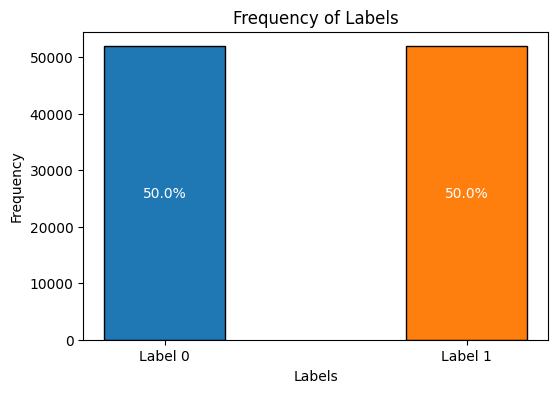

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the frequencies of 0 and 1
label_counts = resampled_data['label'].value_counts()


# Create a DataFrame for plotting
df = pd.DataFrame({'Label': ['Label 0', 'Label 1'], 'Count': label_counts.values})
df['Percentage'] = (df['Count'] / df['Count'].sum()) * 100

# Plot the stacked bar chart
plt.figure(figsize=(6, 4))
plt.bar(df['Label'], df['Count'], color=['#1f77b4', '#ff7f0e'], edgecolor='black', width=0.4)
plt.xlabel('Labels')
plt.ylabel('Frequency')

# Add percentage labels inside the bars
for i, row in df.iterrows():
    plt.text(row['Label'], row['Count'] / 2, f"{row['Percentage']:.1f}%", ha='center', va='center', color='white')

plt.title('Frequency of Labels')
plt.ylabel('Frequency')
plt.show()

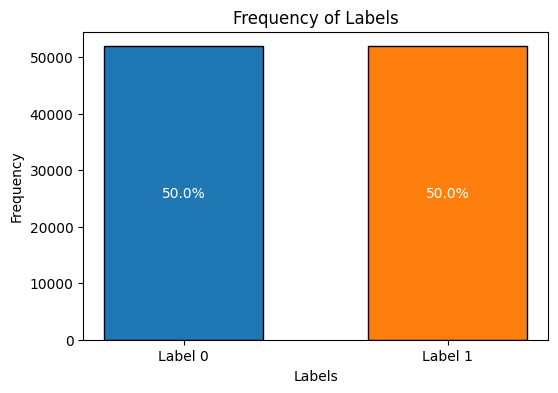

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the frequencies of 0 and 1
label_counts = resampled_data['label'].value_counts()

# Create a DataFrame for plotting
df = pd.DataFrame({'Label': ['Label 0', 'Label 1'], 'Count': label_counts.values})
df['Percentage'] = (df['Count'] / df['Count'].sum()) * 100

# Plot the stacked bar chart
plt.figure(figsize=(6, 4))

# Set the positions for the bars
bar_positions = [0, 0.05]  # Adjust the second value to control the gap

# Reduce the bar width to half
bar_width = 0.03

# Plot the bars with reduced width and adjusted positions
plt.bar(bar_positions, df['Count'], color=['#1f77b4', '#ff7f0e'], edgecolor='black', width=bar_width)

# Adjust x-axis ticks and labels
plt.xticks(bar_positions, df['Label'])  # Center ticks under the bars
plt.xlabel('Labels')
plt.ylabel('Frequency')

# Add percentage labels inside the bars (adjusted for reduced width)
for i, row in df.iterrows():
    plt.text(bar_positions[i], row['Count'] / 2, f"{row['Percentage']:.1f}%", ha='center', va='center', color='white')

plt.title('Frequency of Labels')
plt.ylabel('Frequency')
plt.show()

#Shuffle

In [ ]:
from sklearn.utils import shuffle

# Assuming your dataset is in a Pandas DataFrame called 'df'
resampled_data = shuffle(resampled_data)

# If you want to reset the index after shuffling:
resampled_data = resampled_data.reset_index(drop=True)



In [ ]:
X_train = resampled_data.drop(columns=['label'])
y_train = resampled_data['label']

In [ ]:
print(f"Before PCA, training dataset shape: {X_train.shape}")
print(y_train.shape)

Before PCA, training dataset shape: (103780, 42)
(103780,)


#PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.98)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
print(f"After PCA, training dataset shape: {X_train_pca.shape}")

After PCA, training dataset shape: (103780, 29)


In [ ]:
print(f"The variance ratio: {pca.explained_variance_ratio_}")
print(f"The total variance ratio: {pca.explained_variance_ratio_.sum()}")

The variance ratio: [0.16335367 0.10309749 0.0882179  0.07133258 0.06565969 0.05539277
 0.04801806 0.04247068 0.03923926 0.03605259 0.02644163 0.02549713
 0.02271788 0.02158391 0.02049122 0.0189676  0.01764698 0.01674714
 0.01484912 0.01414482 0.01190126 0.01088614 0.00976235 0.00843235
 0.0080031  0.00707922 0.00619262 0.00566902 0.0055311 ]
The total variance ratio: 0.9853792732290433


In [ ]:
X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)
X_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,-0.491994,2.919906,-1.437054,-0.523122,-0.453143,-0.728235,-0.802382,-0.795983,-0.723093,2.129728,...,-0.029314,0.973012,-0.165835,-0.128772,-0.006896,-0.271625,0.274075,0.054054,-0.063513,-0.037186
1,-0.697769,1.367378,0.348910,1.298217,-0.372207,-1.117799,0.009734,1.996598,1.347350,-0.065391,...,0.346956,-0.177164,0.492556,1.555828,-0.684962,-0.230164,-0.319445,0.130974,-0.029513,-0.311246
2,-1.957297,-0.392595,-0.036011,-0.501814,-0.028948,-0.378285,-0.407498,0.151380,1.576667,-0.182879,...,-0.282412,-0.218516,0.061708,0.005953,0.279655,0.053273,-0.076402,-0.244130,-0.739585,-0.085509
3,0.824364,1.374861,-2.220425,0.896686,-0.813025,0.544720,0.005884,0.718697,-0.680451,-2.597344,...,0.106179,0.210959,-0.084680,0.110196,0.222117,0.338004,0.387431,0.315886,-0.099721,-0.168959
4,-1.322156,-0.869668,0.775210,-0.713190,0.062317,-1.315012,-0.393777,0.674842,1.366661,-0.790356,...,1.923046,-0.502470,2.507649,0.136259,-0.425366,-0.767415,-0.134145,-0.150806,-0.123966,0.099525


In [ ]:
print(X_train_pca.shape)
print(X_test_pca.shape)
print(y_train.shape)
print(y_test.shape)

(103780, 29)
(53952, 29)
(103780,)
(53952,)


#Splitting into Labeled & Unlabeled

In [ ]:
from sklearn.model_selection import train_test_split


X1, X2, y1, y2 = train_test_split(
    X_train_pca, y_train, train_size=0.12, random_state=42
)

In [ ]:
print(f'train dataset shape: ',X1.shape)
print(f'target dataset shape: ',y1.shape)

train dataset shape:  (12453, 29)
target dataset shape:  (12453,)


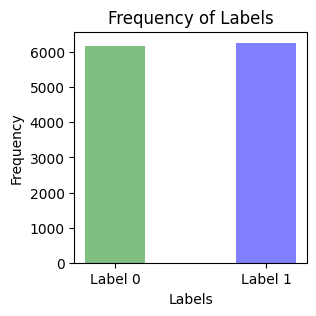

In [ ]:
# Count the frequencies of 0 and 1
label_counts = y1.value_counts() #previously y_labeled

# Plot the histogram (or bar chart)
plt.figure(figsize=(3, 3))
plt.bar(label_counts.index, label_counts.values, color=['blue', 'green'], alpha=0.5, width= 0.4)
plt.xticks([0, 1], ['Label 0', 'Label 1'])  # Set x-tick labels
plt.title('Frequency of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print(label_counts)

label
1    6267
0    6186
Name: count, dtype: int64


#Label Spreading semi-supervised learning

In [ ]:
from numpy import concatenate
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import LabelSpreading
from sklearn.tree import DecisionTreeClassifier

In [ ]:
n = 0.05
avg_accuracy_list_lb = []  # To store average accuracy for each n
error_margin_list_lb = []  # To store error margin for each n
out = 1
for i in range(1, 20):
    accuracy_scores = []  # To store accuracy scores for 10 runs

    for _ in range(10):  # Run the model 10 times
        X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(
            X1, y1, train_size=n, random_state=42
        )

        # create "no label" for unlabeled data
        nolabel = [-1 for _ in range(len(y_unlabeled))]

        # create the training dataset input
        X_train_mixed = concatenate((X_labeled, X_unlabeled))

        # recombine training dataset labels
        y_train_mixed = concatenate((y_labeled, nolabel))

        # define model
        model = LabelSpreading(kernel='rbf', gamma=20, n_neighbors=7, alpha=0.2, max_iter=100, tol=0.001)

        model.fit(X_train_mixed, y_train_mixed)

        # make predictions on hold out test set
        yhat = model.predict(X_test_pca)
        # calculate score for test set
        score = accuracy_score(y_test, yhat)
        accuracy_scores.append(score)

    # Calculate average accuracy and error margin
    avg_accuracy = np.mean(accuracy_scores)
    error_margin = np.std(accuracy_scores) / np.sqrt(len(accuracy_scores))  # Standard error

    avg_accuracy_list_lb.append(avg_accuracy)
    error_margin_list_lb.append(error_margin)

    print('out:',out)
    out = out + 1
    n = n + 0.05

/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in

out: 1


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in

out: 2


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in

out: 3


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in

out: 4


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in

KeyboardInterrupt: 

In [ ]:
print('average accuracy score:', avg_accuracy_list_lb)
print('error margin:', error_margin_list_lb)

average accuracy score: [0.7501668149466191, 0.7551712633451956, 0.7582110023724793, 0.759656731909846, 0.757302787663108, 0.7593972419928826, 0.7602498517200474, 0.7579329774614472, 0.7593972419928826, 0.7578959074733096, 0.7579700474495848, 0.7592674970344009, 0.7604166666666667, 0.7621218861209964, 0.7625667259786477, 0.7635305456702255, 0.7649577402135231, 0.7654211150652432, 0.7653840450771056]
error margin: [3.510833468576701e-17, 3.510833468576701e-17, 0.0, 3.510833468576701e-17, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.510833468576701e-17, 3.510833468576701e-17, 0.0, 0.0, 3.510833468576701e-17, 0.0, 3.510833468576701e-17, 0.0]


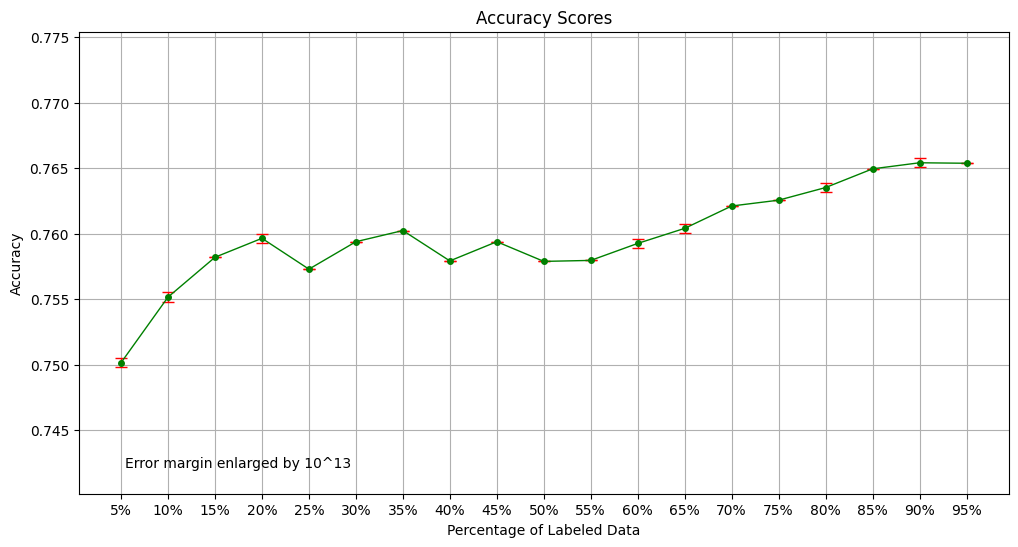

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming score_list is already populated

plt.figure(figsize=(12, 6))
# Create x-values as percentages from 5% to 95%
x_values = np.arange(0.05, 1, 0.05)  # Start at 5%, increment by 5%, end at 95%
scaled_error = [e * 1e13 for e in error_margin_list_lb]  # Increased scaling factor
# Plot the data
plt.errorbar(x_values, avg_accuracy_list_lb, yerr=scaled_error, ecolor='red',
             marker='o', markersize=4, linestyle='-', linewidth=1, capsize=4,
             color='green', elinewidth=1, capthick=1
             )

# Customize the x-axis labels to show percentages
plt.xticks(x_values, [f'{int(p*100)}%' for p in x_values])  # Convert to percentage labels


# Add title and labels
plt.title('Accuracy Scores')
plt.xlabel('Percentage of Labeled Data')  # Customize x-axis label
plt.ylabel('Accuracy')
# Add sidenote using text or annotate
plt.text(
    0.05,  # Adjust x-coordinate for positioning
    0.05,  # Adjust y-coordinate for positioning
    'Error margin enlarged by 10^13',  # Your sidenote text
    transform=plt.gca().transAxes,  # Use axes coordinates
    fontsize=10,  # Adjust fontsize as needed
    ha='left',  # Horizontal alignment
    va='bottom'  # Vertical alignment
)
plt.ylim(min(avg_accuracy_list_lb) - 0.01, max(avg_accuracy_list_lb) + 0.01)
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from numpy import concatenate
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelSpreading


n = 0.05
accuracy_list_lb = []
precision_list_lb = []
recall_list_lb = []
f1_list_lb = []
out = 1

for i in range(1, 20):

    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(
        X1, y1, train_size=n, random_state=42
    )

    nolabel = [-1 for _ in range(len(y_unlabeled))]
    X_train_mixed = concatenate((X_labeled, X_unlabeled))
    y_train_mixed = concatenate((y_labeled, nolabel))

    model = LabelSpreading(kernel='rbf', gamma=20, n_neighbors=7, alpha=0.2, max_iter=100, tol=0.001)
    model.fit(X_train_mixed, y_train_mixed)

    yhat = model.predict(X_test_pca)

    accuracy_list_lb.append(accuracy_score(y_test, yhat))
    precision_list_lb.append(precision_score(y_test, yhat))
    recall_list_lb.append(recall_score(y_test, yhat))
    f1_list_lb.append(f1_score(y_test, yhat))

    print('out:', out)
    out = out + 1
    n = n + 0.05



/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


out: 1


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


out: 2


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


out: 3


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


out: 4


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


out: 5


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


out: 6


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


out: 7


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


out: 8


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


out: 9


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


out: 10


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


out: 11


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


out: 12


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


out: 13


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


out: 14


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


out: 15


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


out: 16


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


out: 17


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


out: 18
out: 19


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


In [ ]:
print('Accuracy:', accuracy_list_lb)
print('Precision:', precision_list_lb)
print('Recall:', recall_list_lb)
print('F1-score:', f1_list_lb)

Accuracy: [0.7475348457888493, 0.7518349644128114, 0.7588226571767497, 0.7604537366548043, 0.7610653914590747, 0.763196915776987, 0.7658844899169632, 0.7652172301304864, 0.7678491992882562, 0.768145759193357, 0.7672931494661922, 0.7659956998813761, 0.7643831553973903, 0.7623813760379596, 0.7637715005931198, 0.763845640569395, 0.7643090154211151, 0.765346975088968, 0.7652543001186239]
Precision: [0.6040004075118008, 0.6091930330825518, 0.6170234950646462, 0.6184539519377691, 0.617633936232282, 0.6196525441186569, 0.6226174473511874, 0.622081192011865, 0.6252297873816378, 0.6256292747283269, 0.6241754446554999, 0.6225856429678086, 0.6204204615489968, 0.6181991944842652, 0.6199499708734537, 0.6199116710602897, 0.6201709401709402, 0.621385500890777, 0.621462142783629]
Recall: [0.9007393902562544, 0.8980553023397144, 0.8990681657044465, 0.9019041831256963, 0.9113744555859414, 0.914007900334245, 0.9148181910260306, 0.9134001823154057, 0.9128937506330396, 0.9125898916236199, 0.91527397954016,

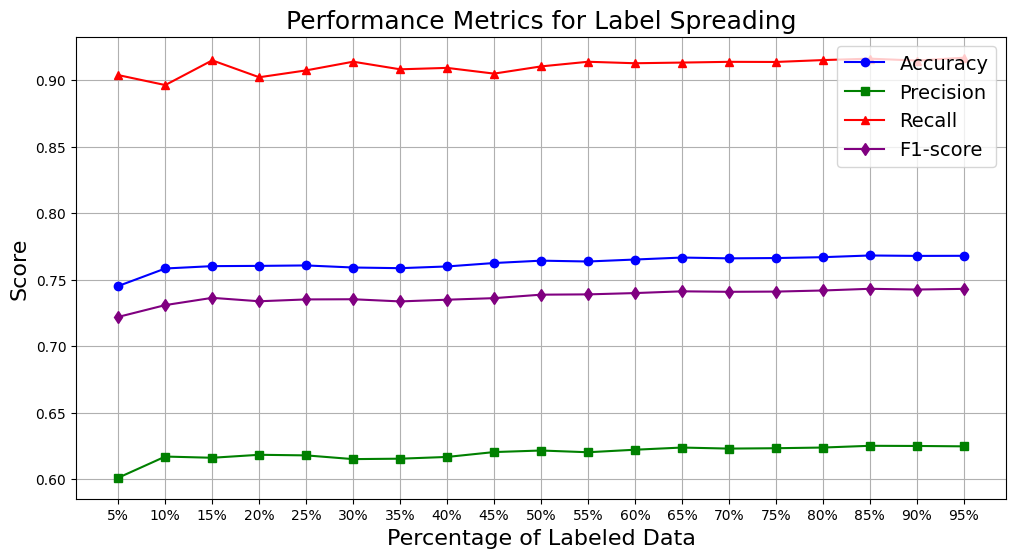

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Plotting the metrics
x_values = np.arange(0.05, 1, 0.05)  # Values for the x-axis (percentage of labeled data)

plt.figure(figsize=(12, 6))  # Adjust figure size as needed

plt.plot(x_values, accuracy_list_lb, marker='o', linestyle='-', color='blue', label='Accuracy')
plt.plot(x_values, precision_list_lb, marker='s', linestyle='-', color='green', label='Precision')
plt.plot(x_values, recall_list_lb, marker='^', linestyle='-', color='red', label='Recall')
plt.plot(x_values, f1_list_lb, marker='d', linestyle='-', color='purple', label='F1-score')

plt.xticks(x_values, [f'{int(p*100)}%' for p in x_values])  # Format x-axis ticks as percentages
plt.title('Performance Metrics for Label Spreading', fontsize=18)
plt.xlabel('Percentage of Labeled Data', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.grid(True)
plt.legend(fontsize=14)  # Show the legend
plt.show()

#Self_Training


In [ ]:
from numpy import concatenate
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

In [ ]:
n = 0.05
avg_accuracy_list_st = []  # To store average accuracy for each n
error_margin_list_st = []  # To store error margin for each n
out = 1
#base_classifier = DecisionTreeClassifier(min_samples_split=500, max_depth=8, random_state=42)
base_classifier = KNeighborsClassifier(n_neighbors=10)
for i in range(1, 20):
    accuracy_scores_st = []  # To store accuracy scores for 10 runs
    ins = 1

    for _ in range(10):  # Run the model 10 times
        X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(
            X1, y1, train_size=n, random_state=42
        )

        # create "no label" for unlabeled data
        nolabel = [-1 for _ in range(len(y_unlabeled))]

        # create the training dataset input
        X_train_mixed = concatenate((X_labeled, X_unlabeled))

        # recombine training dataset labels
        y_train_mixed = concatenate((y_labeled, nolabel))

        # define model
        self_training_clf = SelfTrainingClassifier(base_classifier, threshold=0.9)

        self_training_clf.fit(X_train_mixed, y_train_mixed)

        # make predictions on hold out test set
        yhat = self_training_clf.predict(X_test_pca)
        # calculate score for test set
        score = accuracy_score(y_test, yhat)
        accuracy_scores_st.append(score)
        print(ins)
        ins = ins +1

    # Calculate average accuracy and error margin
    avg_accuracy_st = np.mean(accuracy_scores_st)
    error_margin_st = np.std(accuracy_scores_st) / np.sqrt(len(accuracy_scores_st))  # Standard error

    avg_accuracy_list_st.append(avg_accuracy_st)
    error_margin_list_st.append(error_margin_st)

    n = n + 0.05
    print('out:',out)
    out = out + 1

1
2
3
4
5
6
7
8
9
10
out: 1
1
2
3
4
5
6
7
8
9
10
out: 2
1
2
3
4
5
6
7
8
9
10
out: 3
1
2
3
4
5
6
7
8
9
10
out: 4
1
2
3
4
5
6
7
8
9
10
out: 5
1
2
3
4
5
6
7
8
9
10
out: 6
1
2
3
4
5
6
7
8
9
10
out: 7
1
2
3
4
5
6
7
8
9
10
out: 8
1
2
3
4
5
6
7
8
9
10
out: 9
1
2
3
4
5
6
7
8
9
10
out: 10
1
2
3
4
5
6
7
8
9
10
out: 11
1
2
3
4
5
6
7
8
9
10
out: 12
1
2
3
4
5
6
7
8
9
10
out: 13
1
2
3
4
5
6
7
8
9
10
out: 14
1
2
3
4
5
6
7
8
9
10
out: 15
1
2
3
4
5
6
7
8
9
10
out: 16
1
2
3
4
5
6
7
8
9
10
out: 17
1
2
3
4
5
6
7
8
9
10
out: 18
1
2
3
4
5
6
7
8
9
10
out: 19


In [ ]:
print('average accuracy score for Self-Training:', avg_accuracy_list_st)
print('error margin for Self-Training:', error_margin_list_st)

average accuracy score for Self-Training: [0.6672968564650059, 0.7006413107947804, 0.709297153024911, 0.7217341340450771, 0.7233281435349941, 0.7310016310794779, 0.736988434163701, 0.7373220640569393, 0.7402876631079478, 0.7436239620403321, 0.7436981020166072, 0.7447360616844602, 0.7463115361803084, 0.7481650355871886, 0.7481094306049823, 0.7489249703440095, 0.749443950177936, 0.7502038849347568, 0.7499258600237246]
error margin for Self-Training: [0.0, 3.510833468576701e-17, 0.0, 0.0, 0.0, 3.510833468576701e-17, 3.510833468576701e-17, 3.510833468576701e-17, 0.0, 0.0, 3.510833468576701e-17, 3.510833468576701e-17, 0.0, 0.0, 0.0, 0.0, 0.0, 3.510833468576701e-17, 3.510833468576701e-17]


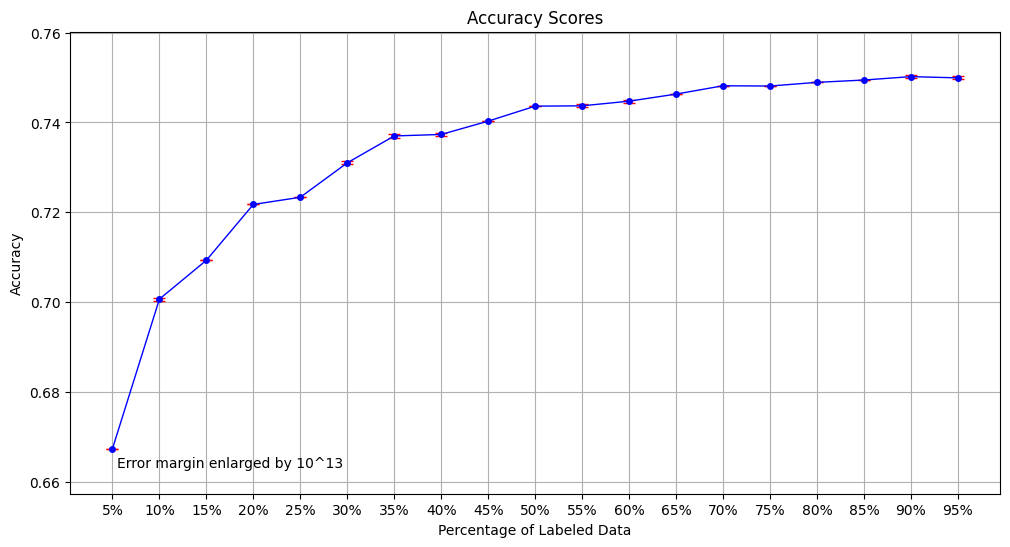

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming score_list is already populated

plt.figure(figsize=(12, 6))
# Create x-values as percentages from 5% to 95%
x_values = np.arange(0.05, 1, 0.05)  # Start at 5%, increment by 5%, end at 95%
scaled_error = [e * 1e13 for e in error_margin_list_st]  # Increased scaling factor
# Plot the data
plt.errorbar(x_values, avg_accuracy_list_st, yerr=scaled_error, ecolor='red',
             marker='o', markersize=4, linestyle='-', linewidth=1, capsize=4,
             color='blue', elinewidth=1, capthick=1
             )

# Customize the x-axis labels to show percentages
plt.xticks(x_values, [f'{int(p*100)}%' for p in x_values])  # Convert to percentage labels

# Add title and labels
plt.title('Accuracy Scores')
plt.xlabel('Percentage of Labeled Data')  # Customize x-axis label
plt.ylabel('Accuracy')
# Add sidenote using text or annotate
plt.text(
    0.05,  # Adjust x-coordinate for positioning
    0.05,  # Adjust y-coordinate for positioning
    'Error margin enlarged by 10^13',  # Your sidenote text
    transform=plt.gca().transAxes,  # Use axes coordinates
    fontsize=10,  # Adjust fontsize as needed
    ha='left',  # Horizontal alignment
    va='bottom'  # Vertical alignment
)
plt.ylim(min(avg_accuracy_list_st) - 0.01, max(avg_accuracy_list_st) + 0.01)
plt.grid(True)
plt.show()

In [ ]:
from numpy import concatenate
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

n = 0.05
accuracy_list_st = []
precision_list_st = []
recall_list_st = []
f1_list_st = []
out = 1
base_classifier = KNeighborsClassifier(n_neighbors=10)

for i in range(1, 20):

    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(
        X1, y1, train_size=n, random_state=42
    )

    nolabel = [-1 for _ in range(len(y_unlabeled))]
    X_train_mixed = concatenate((X_labeled, X_unlabeled))
    y_train_mixed = concatenate((y_labeled, nolabel))

    self_training_clf = SelfTrainingClassifier(base_classifier, threshold=0.9)

    self_training_clf.fit(X_train_mixed, y_train_mixed)

    yhat = self_training_clf.predict(X_test_pca)

    accuracy_list_st.append(accuracy_score(y_test, yhat))
    precision_list_st.append(precision_score(y_test, yhat))
    recall_list_st.append(recall_score(y_test, yhat))
    f1_list_st.append(f1_score(y_test, yhat))

    print('out:', out)
    out = out + 1
    n = n + 0.05


out: 1
out: 2
out: 3
out: 4
out: 5
out: 6
out: 7
out: 8
out: 9
out: 10
out: 11
out: 12
out: 13
out: 14
out: 15
out: 16
out: 17
out: 18
out: 19


In [ ]:
print('Accuracy:', accuracy_list_st)
print('Precision:', precision_list_st)
print('Recall:', recall_list_st)
print('F1-score:', f1_list_st)

Accuracy: [0.6722456998813761, 0.7170447805456702, 0.7251816429418743, 0.7303343712930012, 0.734189650059312, 0.7366362692763938, 0.7394906583629893, 0.7411773428232503, 0.7484430604982206, 0.7504819098457889, 0.7469787959667853, 0.7476460557532622, 0.7484430604982206, 0.7485357354685647, 0.7507043297746144, 0.7520388493475683, 0.7547634934756821, 0.7561536180308422, 0.7556531731909846]
Precision: [0.5280810170691204, 0.5652300524170064, 0.5724981577008106, 0.5780119487225674, 0.5823305407463824, 0.58495719151809, 0.5879136157197146, 0.5895268177876873, 0.5971549065273494, 0.5994303797468354, 0.5960720027741875, 0.5965177418847014, 0.597087683985407, 0.5974206161511052, 0.599936507936508, 0.6012722646310432, 0.6043903220637719, 0.6060713365954159, 0.6052944007700947]
Recall: [0.9823761774536615, 0.9829838954725008, 0.98359161349134, 0.9750329180593538, 0.9680441608427023, 0.9653600729261622, 0.9636888483743543, 0.9640939937202472, 0.960903474121341, 0.9592828927377697, 0.95756102501772

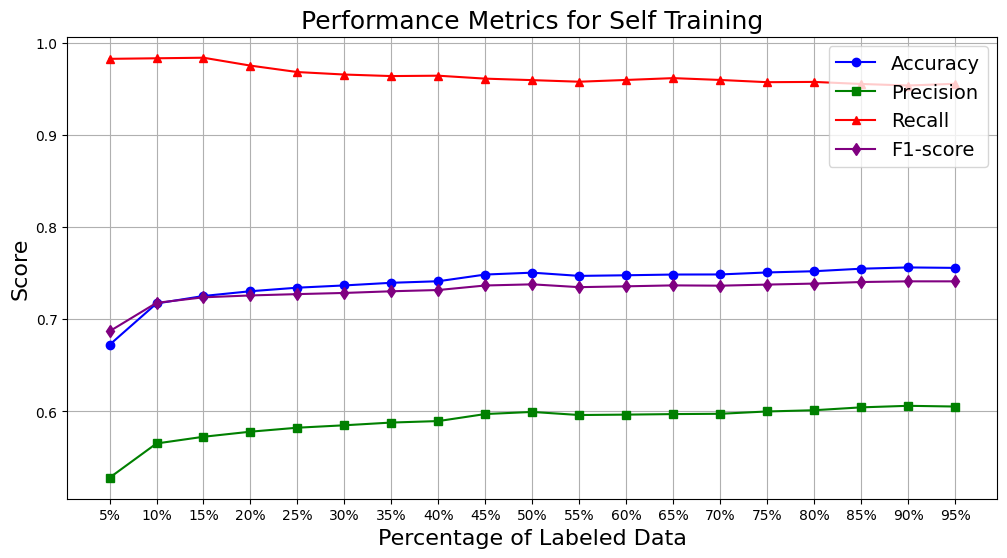

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Plotting the metrics
x_values = np.arange(0.05, 1, 0.05)  # Values for the x-axis (percentage of labeled data)

plt.figure(figsize=(12, 6))  # Adjust figure size as needed

plt.plot(x_values, accuracy_list_st, marker='o', linestyle='-', color='blue', label='Accuracy')
plt.plot(x_values, precision_list_st, marker='s', linestyle='-', color='green', label='Precision')
plt.plot(x_values, recall_list_st, marker='^', linestyle='-', color='red', label='Recall')
plt.plot(x_values, f1_list_st, marker='d', linestyle='-', color='purple', label='F1-score')

plt.xticks(x_values, [f'{int(p*100)}%' for p in x_values])  # Format x-axis ticks as percentages
plt.title('Performance Metrics for Self Training', fontsize=18)
plt.xlabel('Percentage of Labeled Data',fontsize=16)
plt.ylabel('Score',fontsize=16)
plt.grid(True)
plt.legend(fontsize=14)  # Show the legend
plt.show()

#TSVM


In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from numpy import concatenate
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [ ]:
# TSVM Algorithm
def train_tsvm(X_train, y_train, clf, max_iterations, threshold):
    for iteration in range(max_iterations):
        #print(f"\nIteration {iteration + 1}/{max_iterations}")

        # Train on the current labeled data
        clf.fit(X_train[y_train != -1], y_train[y_train != -1])

        # Predict probabilities for the unlabeled data
        probas = clf.predict_proba(X_train[y_train == -1])
        max_probas = np.max(probas, axis=1)
        pseudo_labels = np.argmax(probas, axis=1)

        # Assign pseudo-labels to confident samples
        confident_indices = np.where(max_probas >= threshold)[0]
        y_train[np.where(y_train == -1)[0][confident_indices]] = pseudo_labels[confident_indices]

        print(f"Confident pseudo-labels assigned: {len(confident_indices)}")

        # If no confident samples are found, break early
        if len(confident_indices) == 0:
            print("No confident samples found. Stopping early.")
            break

    return clf

In [ ]:
from numpy import concatenate
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

n = 0.05
accuracy_list_tsvm = []
precision_list_tsvm = []
recall_list_tsvm = []
f1_list_tsvm = []
out = 1
clf = KNeighborsClassifier(n_neighbors=10)

for i in range(1, 20):

    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(
        X1, y1, train_size=n, random_state=42
    )

    nolabel = [-1 for _ in range(len(y_unlabeled))]
    X_train_mixed = concatenate((X_labeled, X_unlabeled))
    y_train_mixed = concatenate((y_labeled, nolabel))

    trained_model = train_tsvm(X_train_mixed.copy(), y_train_mixed.copy(), clf, max_iterations=10, threshold= 0.85)

    yhat = trained_model.predict(X_test_pca)


    accuracy_list_tsvm.append(accuracy_score(y_test, yhat))
    precision_list_tsvm.append(precision_score(y_test, yhat))
    recall_list_tsvm.append(recall_score(y_test, yhat))
    f1_list_tsvm.append(f1_score(y_test, yhat))

    print('out:', out)
    out = out + 1
    n = n + 0.05


Confident pseudo-labels assigned: 7459
Confident pseudo-labels assigned: 2840
Confident pseudo-labels assigned: 717
Confident pseudo-labels assigned: 255
Confident pseudo-labels assigned: 62
Confident pseudo-labels assigned: 11
Confident pseudo-labels assigned: 6
Confident pseudo-labels assigned: 2
Confident pseudo-labels assigned: 0
No confident samples found. Stopping early.
out: 1
Confident pseudo-labels assigned: 7516
Confident pseudo-labels assigned: 1974
Confident pseudo-labels assigned: 737
Confident pseudo-labels assigned: 350
Confident pseudo-labels assigned: 111
Confident pseudo-labels assigned: 38
Confident pseudo-labels assigned: 17
Confident pseudo-labels assigned: 10
Confident pseudo-labels assigned: 3
Confident pseudo-labels assigned: 2
out: 2
Confident pseudo-labels assigned: 7291
Confident pseudo-labels assigned: 1489
Confident pseudo-labels assigned: 644
Confident pseudo-labels assigned: 259
Confident pseudo-labels assigned: 95
Confident pseudo-labels assigned: 49
Con

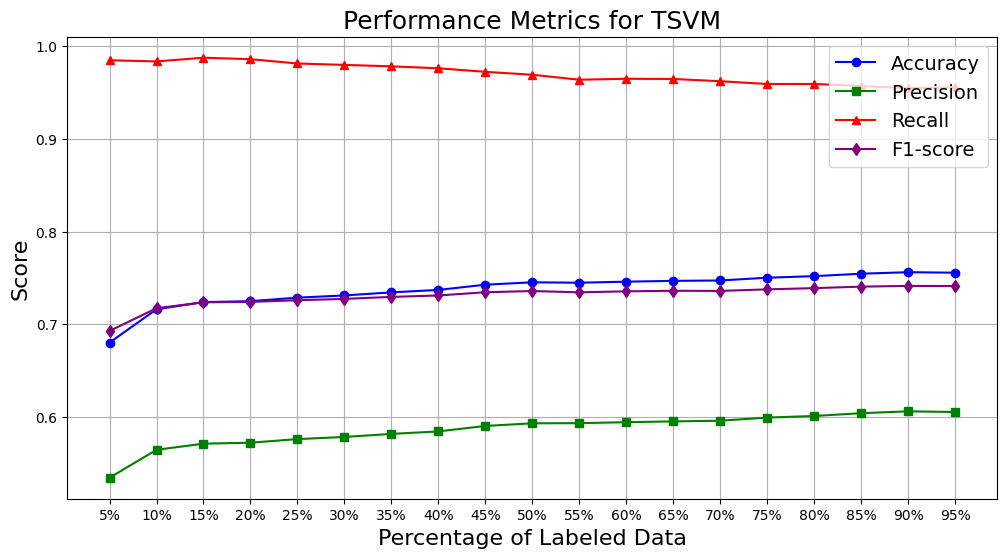

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Plotting the metrics
x_values = np.arange(0.05, 1, 0.05)  # Values for the x-axis (percentage of labeled data)

plt.figure(figsize=(12, 6))  # Adjust figure size as needed

plt.plot(x_values, accuracy_list_tsvm, marker='o', linestyle='-', color='blue', label='Accuracy')
plt.plot(x_values, precision_list_tsvm, marker='s', linestyle='-', color='green', label='Precision')
plt.plot(x_values, recall_list_tsvm, marker='^', linestyle='-', color='red', label='Recall')
plt.plot(x_values, f1_list_tsvm, marker='d', linestyle='-', color='purple', label='F1-score')

plt.xticks(x_values, [f'{int(p*100)}%' for p in x_values])  # Format x-axis ticks as percentages
plt.title('Performance Metrics for TSVM',fontsize=18)
plt.xlabel('Percentage of Labeled Data',fontsize=16)
plt.ylabel('Score',fontsize=16)
plt.grid(True)
plt.legend(fontsize=14)  # Show the legend
plt.show()

In [ ]:
print('Accuracy:', accuracy_list_tsvm)
print('Precision:', precision_list_tsvm)
print('Recall:', recall_list_tsvm)
print('F1-score:', f1_list_tsvm)


Accuracy: [0.680011862396204, 0.7159882858837485, 0.7237359134045077, 0.7247738730723606, 0.7285550118623962, 0.7309460260972717, 0.7342637900355872, 0.736895759193357, 0.7425674673784104, 0.7451252965599051, 0.7446804567022538, 0.7458296263345195, 0.7466822360616845, 0.7471085409252669, 0.750092674970344, 0.751779359430605, 0.7544113285883749, 0.7560424080664294, 0.7555048932384342]
Precision: [0.5340784270650264, 0.564241103848947, 0.5708473584077272, 0.5719152935647781, 0.5757746813630826, 0.5781296683597251, 0.581389749917241, 0.5840933191940615, 0.5899775708974714, 0.5928449744463373, 0.5930149235131009, 0.5940452065471551, 0.5949220823834359, 0.5956366372014293, 0.5990260253612877, 0.6007547887859952, 0.6037567084078712, 0.6057772636720005, 0.6050649142490784]
Recall: [0.9849589790337283, 0.9836928998278133, 0.987693710118505, 0.9861237719031702, 0.9814646004254026, 0.9799453053783045, 0.9783753671629697, 0.9762989972652689, 0.9724501164792869, 0.9693102400486174, 0.9639420642155

#Plotting three graphs together

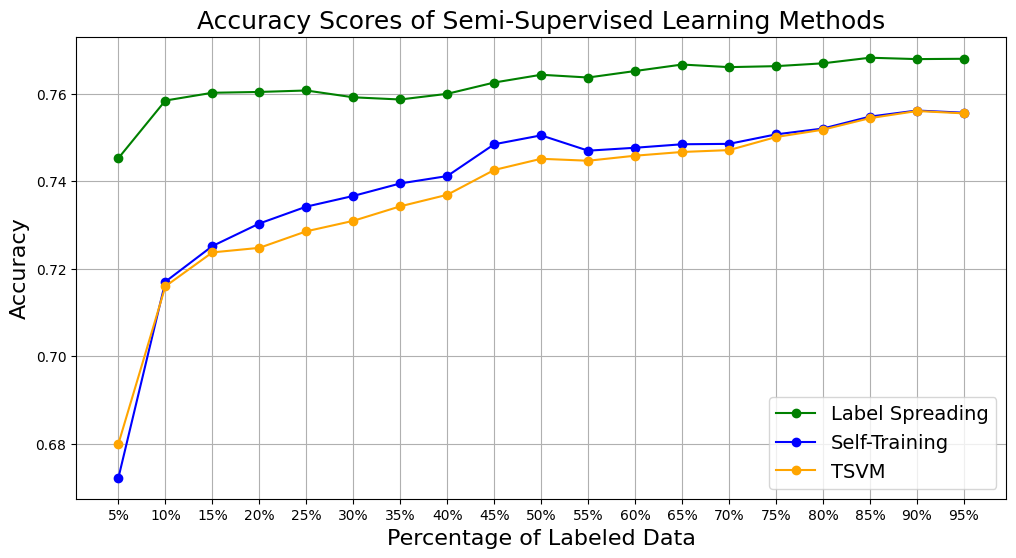

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming score_list, score_list_st, and score_list_tsvm are already populated

plt.figure(figsize=(12, 6))
x_values = np.arange(0.05, 1, 0.05)

# Plot Label Spreading (Green)
plt.plot(x_values, accuracy_list_lb, marker='o', linestyle='-', color='green', label='Label Spreading')

# Plot Self-Training (Blue)
plt.plot(x_values, accuracy_list_st, marker='o', linestyle='-', color='blue', label='Self-Training')

# Plot TSVM (Orange)
plt.plot(x_values, accuracy_list_tsvm, marker='o', linestyle='-', color='orange', label='TSVM')

# Customize the plot
plt.xticks(x_values, [f'{int(p*100)}%' for p in x_values])
plt.title('Accuracy Scores of Semi-Supervised Learning Methods',fontsize=18)
plt.xlabel('Percentage of Labeled Data',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.grid(True)
plt.legend(fontsize=14) # Show the legend to identify each line
plt.show()

#END